### Upsampling utils

In [1]:
# imports
from voc_data_reader import VOCDataReader
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

[[[212 214 213]
  [213 215 214]
  [216 218 217]]

 [[211 217 217]
  [213 217 216]
  [214 218 217]]

 [[206 216 215]
  [209 218 217]
  [209 218 217]]]
(375, 500, 3)


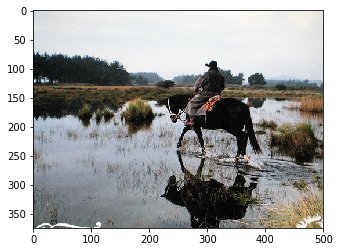

In [2]:
TRAINVAL_ROOT_DIR = '/root/PASCAL-VOC-Dataset/TrainVal'
TEST_ROOT_DIR = '/root/PASCAL-VOC-Dataset/Test'
dsr = VOCDataReader(TRAINVAL_ROOT_DIR, TEST_ROOT_DIR)
for i in dsr.next_train_batch(1, False)['batch']:
    img = i
print(img[0:3,0:3,0:3])
plt.imshow(img)
print(img.shape)

In [3]:
def get_kernel_size(factor):
    return 2 * factor - factor % 2

def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)

def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = get_kernel_size(factor)
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

def upsample_tf(factor, input_img):
    number_of_classes = input_img.shape[2]
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    expanded_img = np.expand_dims(input_img, axis=0)
    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):
                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)
                upsample_filter_np = bilinear_upsample_weights(factor,
                                        number_of_classes)
                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                        output_shape=[1, new_height, new_width, number_of_classes],
                        strides=[1, factor, factor, 1])
                final_result = sess.run(res,
                                feed_dict={upsample_filt_pl: upsample_filter_np,
                                           logits_pl: expanded_img})
                final_result/=255.0
    return final_result.squeeze()

In [4]:
print(upsample_filt(4))

[[0.0625 0.1875 0.1875 0.0625]
 [0.1875 0.5625 0.5625 0.1875]
 [0.1875 0.5625 0.5625 0.1875]
 [0.0625 0.1875 0.1875 0.0625]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0000001
0.0
[[[0.3694989  0.37298477 0.3712418 ]
  [0.5542484  0.55947715 0.5568628 ]
  [0.5551198  0.5603486  0.55773425]]

 [[0.5542484  0.55947715 0.5568628 ]
  [0.83137256 0.8392157  0.8352941 ]
  [0.8326798  0.84052294 0.8366014 ]]

 [[0.5533769  0.5620915  0.5603486 ]
  [0.8300654  0.84313726 0.84052294]
  [0.83180827 0.84400874 0.84095865]]]
(1125, 1500, 3)


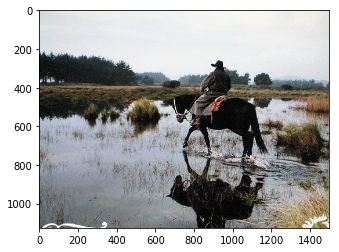

In [5]:
upsampled_img_tf = upsample_tf(factor=3, input_img=img)
print(np.max(upsampled_img_tf))
print(np.min(upsampled_img_tf))
print(upsampled_img_tf[0:3,0:3,0:3])
plt.imshow(upsampled_img_tf)
print(upsampled_img_tf.shape)